In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

In [6]:
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


## arrange data
#female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
#female_df = female_df[keep_syllables]

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]


#female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v01.parquet').astype(float)
#female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [7]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

# use the same number of mice per age - only age 80

/tmp/ipykernel_6407/1834138450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_6407/1834138450.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [8]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)
data=pd.concat([m_data,f_data])

In [9]:
## MI for age in males

In [10]:
X = m_data.to_numpy()
y = list(m_data.index.get_level_values('age'))
mi_score_m = MIR(X,y)

In [11]:
m_indx = np.argsort(mi_score_m)[::-1][0:len(keep_syllables)] # syllble index
impsyl_m= list(m_data.columns[m_indx]) #syllable id

In [12]:
print('10 most informative syllables for male: ',impsyl_m[:10])

10 most informative syllables for male:  [42, 69, 12, 9, 90, 5, 74, 62, 11, 4]


In [13]:
import random
it=100
mi_shf=[]
for i in tqdm(range(it)):
    ytemp = random.shuffle(y)
    mi_temp = MIR(X,y)
    mi_shf.extend(mi_temp)

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
## MI for age in females

In [15]:
X = f_data.to_numpy()
y = list(f_data.index.get_level_values('age'))
mi_score_f = MIR(X,y)

In [16]:
f_indx = np.argsort(mi_score_f)[::-1][0:len(keep_syllables)] # syllble index
impsyl_f= list(f_data.columns[f_indx]) #syllable id
mi_shf_f=[]
it=100
for i in tqdm(range(it)):
    ytemp = random.shuffle(y)
    mi_temp = MIR(X,y)
    mi_shf_f.extend(mi_temp)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
print('10 most informative syllables for female: ',impsyl_f[:10])

10 most informative syllables for female:  [9, 4, 98, 25, 41, 0, 77, 12, 5, 52]


In [18]:
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((mi_score_m,mi_score_f))
mi_df['syll'] = np.concatenate((np.array(m_data.columns),np.array(f_data.columns)))
mi_df['exp'] = ['m']*len(m_data.columns)+['f']*len(f_data.columns)

In [19]:
mi_df['rank'] = mi_df.groupby('exp')['mi'].rank()

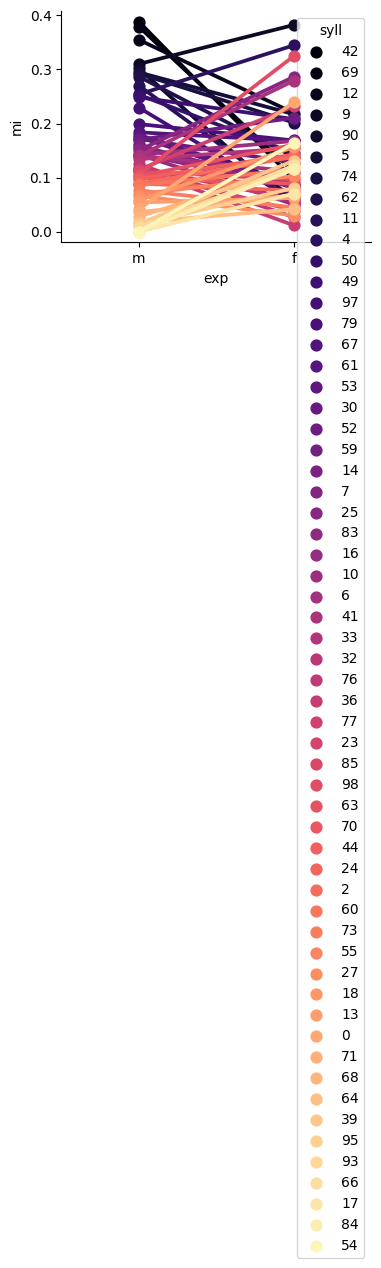

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

sns.pointplot(data=mi_df,x='exp',y='mi',hue='syll',join=True,palette='magma',hue_order=impsyl_m)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_MI_aging.pdf')

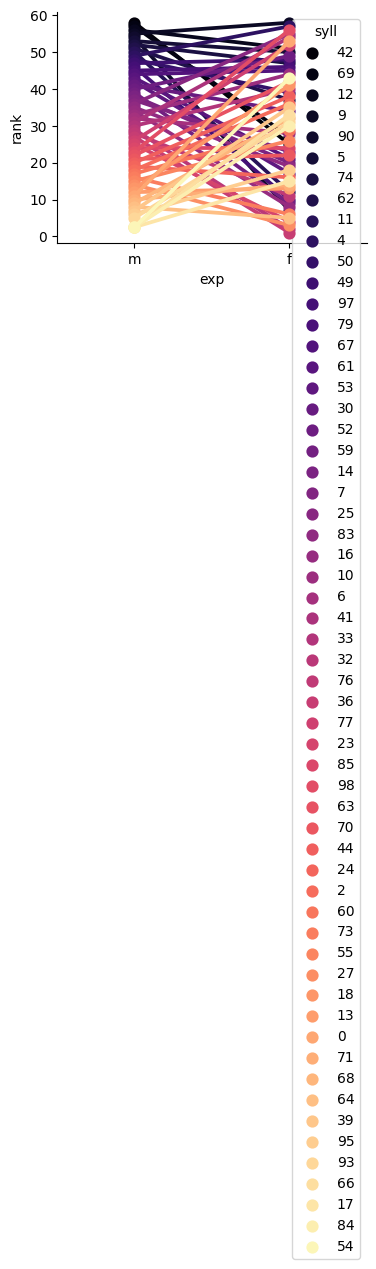

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True,palette='magma',hue_order=impsyl_m)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_MI_aging_rank.pdf')

In [22]:
## plot differently

In [23]:
#X = m_data.to_numpy()
X = m_data.to_numpy()
y = list(m_data.index.get_level_values('age'))
mi_score_m = MIR(X,y)

m_rank = np.argsort(mi_score_m)[::-1]
m_scores = mi_score_m[m_rank]

In [24]:
import random
it=100
mi_shf=[]
for i in tqdm(range(it)):
    ytemp = random.shuffle(y)
    mi_temp = MIR(X,y)
    mi_shf.append(mi_temp)
    
m_sh = np.mean(mi_shf, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
m_sh = np.mean(mi_shf, axis=0)
m_scores_sh = m_sh[m_rank]

In [26]:
#X = f_data.to_numpy()
X = f_data.to_numpy()
y = list(f_data.index.get_level_values('age'))
mi_score_f = MIR(X,y)

f_rank = np.argsort(mi_score_f)
f_scores = mi_score_f[m_rank] ## sorted by males

In [27]:
import random
it=100
mi_shf=[]
for i in tqdm(range(it)):
    ytemp = random.shuffle(y)
    mi_temp = MIR(X,y)
    mi_shf.append(mi_temp)
    
f_sh = np.mean(mi_shf, axis=0)
f_scores_sh = f_sh[m_rank]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

Text(0, 0.5, 'MI score')

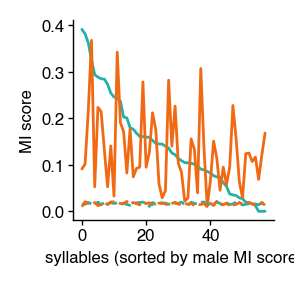

In [49]:
format_plots()
fig = plt.figure(figsize=(1.3, 1.3))
ax = fig.gca()
sns.lineplot(m_scores, ax=ax, color = '#20B2AA', lw=1)
sns.lineplot(f_scores, ax=ax, color = '#f16913',lw=1)
sns.lineplot(m_scores_sh, ax=ax, color = '#20B2AA', lw=1, linestyle='dashed')
sns.lineplot(f_scores_sh, ax=ax, color = '#f16913',lw=1,linestyle='dashed')
sns.despine()
plt.xlabel('syllables (sorted by male MI score)')
plt.ylabel('MI score')

In [50]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_MI_aging_line_normalized.pdf')

In [30]:
## plot the rank

In [31]:
mm_rank = np.argsort(m_rank)[::-1]
mm_rank = m_rank[mm_rank]
ff_rank = f_rank[mm_rank]

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

Text(0, 0.5, 'MI rank')

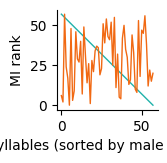

In [32]:
format_plots()
fig = plt.figure(figsize=(1.3, 1.3))
ax = fig.gca()
sns.lineplot(mm_rank, ax=ax, color = '#20B2AA', lw=1)
sns.lineplot(ff_rank, ax=ax, color = '#f16913',lw=1)
sns.despine()
plt.xlabel('syllables (sorted by male MI rank)')
plt.ylabel('MI rank')

In [33]:
## create data to plot
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((m_scores,f_scores))
mi_df['rank'] = np.concatenate((np.array(m_rank),np.array(m_rank)))
mi_df['sex'] = ['m']*len(m_data.columns)+['f']*len(f_data.columns)

In [34]:
format_plots()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

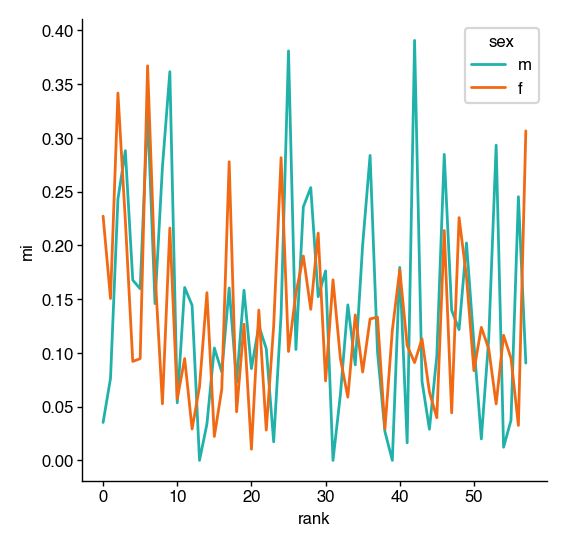

In [35]:
#fig = plt.figure(figsize=(1.3, 1.3))
#ax = fig.gca()
sns.lineplot(data=mi_df, x='rank', y='mi', hue='sex', palette = ['#20B2AA','#f16913'])

#sns.displot(mi_score_m, kind="kde",fill=True,color = '#20B2AA',ax=ax)
#sns.displot(mi_shf, kind="kde",fill=True,color = 'gray',ax=ax)
sns.despine()

In [36]:
mi_df

,mi,rank,sex
0,0.390760,42,m
1,0.380986,25,m
2,0.361678,9,m
3,0.325085,6,m
4,0.293336,53,m
...,...,...,...
111,0.106915,41,f
112,0.116429,54,f
113,0.068622,13,f
114,0.121047,39,f


In [37]:
## MI for age in ontogeny

In [38]:
X = m_norm.to_numpy()
y = list(m_norm.index.get_level_values('age'))
mi_score_m = MIR(X,y)

In [39]:
m_indx = np.argsort(mi_score_m)[::-1][0:len(keep_syllables)] # syllble index
impsyl_m= list(m_norm.columns[m_indx]) #syllable id

In [40]:
print('10 most informative syllables for male: ',impsyl_m[:10])

10 most informative syllables for male:  [42, 69, 12, 90, 9, 5, 74, 62, 11, 50]


In [41]:
## MI for age in longtogeny

In [42]:
X = f_norm.to_numpy()
y = list(f_norm.index.get_level_values('age'))
mi_score_f = MIR(X,y)

In [43]:
f_indx = np.argsort(mi_score_f)[::-1][0:len(keep_syllables)] # syllble index
impsyl_f= list(f_norm.columns[f_indx]) #syllable id

In [44]:
print('10 most informative syllables for female: ',impsyl_f[:10])

10 most informative syllables for female:  [9, 4, 98, 25, 41, 0, 77, 49, 5, 74]


In [45]:
mi_df = pd.DataFrame()
mi_df['mi'] = np.concatenate((mi_score_m,mi_score_f))
mi_df['syll'] = np.concatenate((np.array(m_norm.columns),np.array(f_norm.columns)))
#mi_df['rank']  = np.concatenate((np.array(impsyl_ont),np.array(impsyl_long)))
mi_df['exp'] = ['m']*len(m_data.columns)+['f']*len(f_data.columns)

In [46]:
mi_df['rank'] = mi_df.groupby('exp')['mi'].rank()

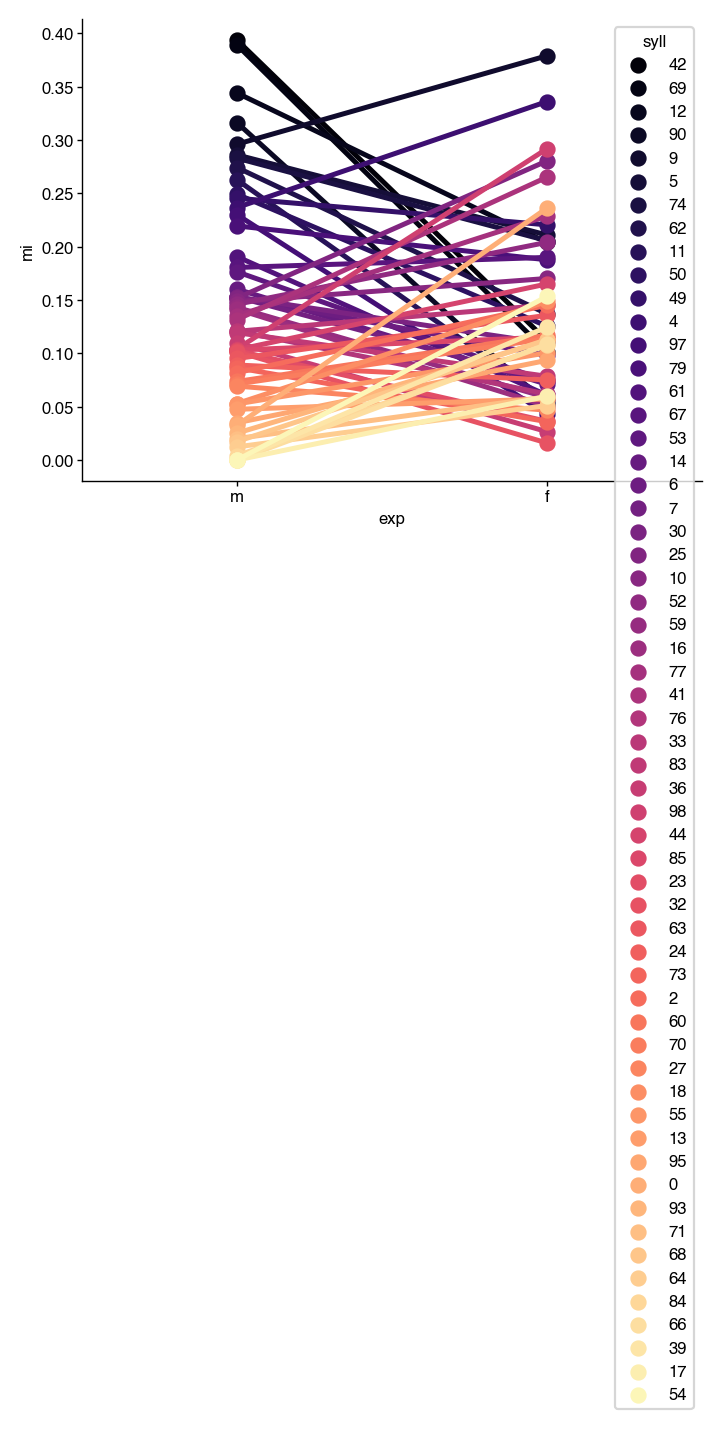

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

sns.pointplot(data=mi_df,x='exp',y='mi',hue='syll',join=True,palette='magma',hue_order=impsyl_m)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_MI_aging_norm.pdf')

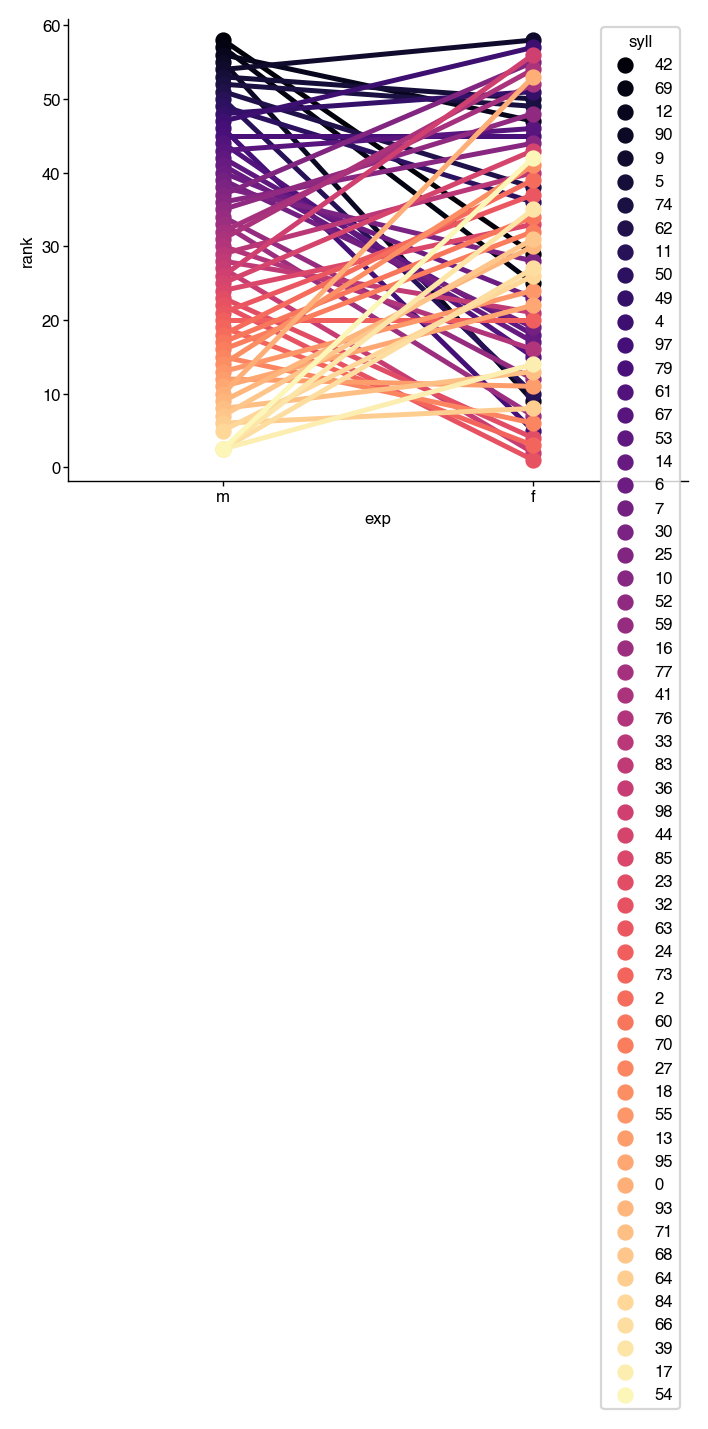

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3)

sns.pointplot(data=mi_df,x='exp',y='rank',hue='syll',join=True,palette='magma',hue_order=impsyl_m)

sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_MI_aging_rank_norm.pdf')